## reference
https://www.tensorflow.org/text/tutorials/text_generation

# **Importing libraries**

In [44]:
import numpy as np
import os
import time

import tensorflow as tf
from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional
from tensorflow.keras.models import Sequential

# **Download the Shakespeare dataset**

In [45]:
path_to_file = tf.keras.utils.get_file('shakespeare.txt', 'https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt')

# **Read the data**

In [46]:
# Read, then decode for py2 compat.
text = open(path_to_file, 'rb').read().decode(encoding='utf-8')
# length of text is the number of characters in it
print(f'Length of text: {len(text)} characters')

Length of text: 1115394 characters


In [47]:
# Take a look at the first 250 characters in text
print(text[:250])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.



In [48]:
# The unique characters in the file
vocab = sorted(set(text))
print(f'{len(vocab)} unique characters')
print(vocab)

65 unique characters
['\n', ' ', '!', '$', '&', "'", ',', '-', '.', '3', ':', ';', '?', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


# **Process the text**

## Vectorize the text
Before training, you need to convert the strings to a numerical representation.

The **preprocessing.StringLookup** layer can convert each character into a numeric 
ID. It just needs the text to be split into tokens first.

In [49]:
ids_from_chars = preprocessing.StringLookup(
    vocabulary=list(vocab), mask_token=None)

### **Example**

In [50]:
# Example
temp_string_list = ['a','b','k','Q','R']
ids = ids_from_chars(temp_string_list)
print(ids)

tf.Tensor([40 41 50 30 31], shape=(5,), dtype=int64)


You can **tf.strings.reduce_join** to join the characters back into strings.

In [51]:
def text_from_ids(ids):
  return tf.strings.reduce_join(chars_from_ids(ids), axis=-1)

In [52]:
print(text_from_ids(ids))

tf.Tensor(b'abkQR', shape=(), dtype=string)




---


Since the goal is to generate text, it will also be important to invert this representation and recover human-readable strings from it. For this you can use **preprocessing.StringLookup(..., invert=True)**.

In [53]:
chars_from_ids = tf.keras.layers.experimental.preprocessing.StringLookup(
    vocabulary=ids_from_chars.get_vocabulary(), invert=True, mask_token=None)



---


The input to the model will be a sequence of characters, and you train the model to predict the output i.e. the following character at each time step.

### **Create training examples and targets**

Next divide the text into example sequences. Each input sequence will contain seq_length characters from the text.

For each input sequence, the corresponding targets contain the same length of text, except shifted one character to the right.

So break the text into chunks of **seq_length+1**. For example, say seq_length is 4 and our text is "Hello". The input sequence would be "Hell", and the target sequence "ello".

To do this first use the **tf.data.Dataset.from_tensor_slices** function to convert the text vector into a stream of character indices.

In [54]:
all_ids = ids_from_chars(tf.strings.unicode_split(text, 'UTF-8'))
all_ids

<tf.Tensor: shape=(1115394,), dtype=int64, numpy=array([19, 48, 57, ..., 46,  9,  1])>

In [55]:
ids_dataset = tf.data.Dataset.from_tensor_slices(all_ids)

In [56]:
for ids in ids_dataset.take(10):
    print(chars_from_ids(ids).numpy().decode('utf-8'))

F
i
r
s
t
 
C
i
t
i


In [57]:
seq_length = 100
examples_per_epoch = len(text)//(seq_length+1)

The **batch** method lets you easily convert these individual characters to sequences of the desired size.


Example:
```
>>> dataset = tf.data.Dataset.range(8)
>>> dataset = dataset.batch(3)
>>> list(dataset.as_numpy_iterator())

[array([0, 1, 2]), array([3, 4, 5]), array([6, 7])]
```



In [58]:
sequences = ids_dataset.batch(seq_length+1, drop_remainder=True)

for seq in sequences.take(1):
  print(chars_from_ids(seq))

tf.Tensor(
[b'F' b'i' b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':'
 b'\n' b'B' b'e' b'f' b'o' b'r' b'e' b' ' b'w' b'e' b' ' b'p' b'r' b'o'
 b'c' b'e' b'e' b'd' b' ' b'a' b'n' b'y' b' ' b'f' b'u' b'r' b't' b'h'
 b'e' b'r' b',' b' ' b'h' b'e' b'a' b'r' b' ' b'm' b'e' b' ' b's' b'p'
 b'e' b'a' b'k' b'.' b'\n' b'\n' b'A' b'l' b'l' b':' b'\n' b'S' b'p' b'e'
 b'a' b'k' b',' b' ' b's' b'p' b'e' b'a' b'k' b'.' b'\n' b'\n' b'F' b'i'
 b'r' b's' b't' b' ' b'C' b'i' b't' b'i' b'z' b'e' b'n' b':' b'\n' b'Y'
 b'o' b'u' b' '], shape=(101,), dtype=string)


It's easier to see what this is doing if you join the tokens back into strings:

In [59]:
for seq in sequences.take(5):
  print(text_from_ids(seq).numpy())

b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'
b"now Caius Marcius is chief enemy to the people.\n\nAll:\nWe know't, we know't.\n\nFirst Citizen:\nLet us ki"
b"ll him, and we'll have corn at our own price.\nIs't a verdict?\n\nAll:\nNo more talking on't; let it be d"
b'one: away, away!\n\nSecond Citizen:\nOne word, good citizens.\n\nFirst Citizen:\nWe are accounted poor citi'


For training you'll need a dataset of **(input, label)** pairs. Where input and label are sequences. At each time step the input is the current character and the label is the next character.

Here's a function that takes a sequence as input, duplicates, and shifts it to align the input and label for each timestep:

In [60]:
def split_input_target(sequence):
    input_text = sequence[:-1] # Tensorflo
    target_text = sequence[1:] # ensorflow
    return input_text, target_text

In [61]:
# Example
split_input_target(list("Tensorflow"))

(['T', 'e', 'n', 's', 'o', 'r', 'f', 'l', 'o'],
 ['e', 'n', 's', 'o', 'r', 'f', 'l', 'o', 'w'])

In [62]:
dataset = sequences.map(split_input_target)

In [63]:
for input_example, target_example in dataset.take(2):
    print("Input :", text_from_ids(input_example).numpy())
    print("Target:", text_from_ids(target_example).numpy())

Input : b'First Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou'
Target: b'irst Citizen:\nBefore we proceed any further, hear me speak.\n\nAll:\nSpeak, speak.\n\nFirst Citizen:\nYou '
Input : b'are all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you '
Target: b're all resolved rather to die than to famish?\n\nAll:\nResolved. resolved.\n\nFirst Citizen:\nFirst, you k'


### **Create training batches**
You used **tf.data** to split the text into manageable sequences. But before feeding this data into the model, you need to shuffle the data and pack it into batches.

In [64]:
# Batch size
BATCH_SIZE = 64

# Buffer size to shuffle the dataset
# (TF data is designed to work with possibly infinite sequences,
# so it doesn't attempt to shuffle the entire sequence in memory. Instead,
# it maintains a buffer in which it shuffles elements).
BUFFER_SIZE = 10000

dataset = (
    dataset
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE, drop_remainder=True)
    .prefetch(tf.data.experimental.AUTOTUNE))

dataset

<PrefetchDataset shapes: ((64, 100), (64, 100)), types: (tf.int64, tf.int64)>

# **Build The Model**

This model has three layers:



*   **tf.keras.layers.Embedding**: The input layer. A trainable lookup table that will map each character-ID to a vector with **embedding_dim** dimensions;

*   **tf.keras.layers.GRU**: A type of RNN with size **units=rnn_units** (You can also use an LSTM layer here.)

*   **tf.keras.layers.Dense**: The output layer, with **vocab_size** outputs. It outputs one logit for each character in the vocabulary. These are the log-likelihood of each character according to the model.

In [65]:
# Length of the vocabulary in chars
vocab_size = len(vocab)

# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

In [66]:
class MyModel(tf.keras.Model):

  def __init__(self, vocab_size, embedding_dim, rnn_units):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(rnn_units,
                                   return_sequences=True,
                                   return_state=True)
    self.dense = tf.keras.layers.Dense(vocab_size)

  def call(self, inputs, states=None, return_state=False, training=False):
    x = inputs
    x = self.embedding(x, training=training)
    if states is None:
      states = self.gru.get_initial_state(x)
    x, states = self.gru(x, initial_state=states, training=training)
    x = self.dense(x, training=training)

    if return_state:
      return x, states
    else:
      return x

In [67]:
# model = Sequential()
# model.add(Embedding(vocab_size, embedding_dim)
# model.add(LSTM(200))
# model.add(Dense(vocab_size)
# adam = Adam(lr=0.01)
# model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
# # earlystop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto')

In [68]:
model = MyModel(
    # Be sure the vocabulary size matches the `StringLookup` layers.
    vocab_size=len(ids_from_chars.get_vocabulary()),
    embedding_dim=embedding_dim,
    rnn_units=rnn_units)

### **Try the model**

Now run the model to see that it behaves as expected.

First check the shape of the output:

In [69]:
for input_example_batch, target_example_batch in dataset.take(1):
    example_batch_predictions = model(input_example_batch)
    print(example_batch_predictions.shape, "# (batch_size, sequence_length, vocab_size)")

(64, 100, 66) # (batch_size, sequence_length, vocab_size)


In [70]:
model.summary()

Model: "my_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  16896     
_________________________________________________________________
gru (GRU)                    multiple                  3938304   
_________________________________________________________________
dense_3 (Dense)              multiple                  67650     
Total params: 4,022,850
Trainable params: 4,022,850
Non-trainable params: 0
_________________________________________________________________


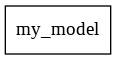

In [71]:
tf.keras.utils.plot_model(
    model
)

# **Train the model**

In [72]:
loss = tf.losses.SparseCategoricalCrossentropy(from_logits=True)

In [41]:
example_batch_loss = loss(target_example_batch, example_batch_predictions)
mean_loss = example_batch_loss.numpy().mean()
print("Prediction shape: ", example_batch_predictions.shape, " # (batch_size, sequence_length, vocab_size)")
print("Mean loss:        ", mean_loss)

Prediction shape:  (64, 100, 66)  # (batch_size, sequence_length, vocab_size)
Mean loss:         4.190166


In [42]:
tf.exp(mean_loss).numpy()

66.03375

In [58]:
adam = Adam(lr=0.01) # added
model.compile(optimizer= adam, loss=loss)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


### Configure **checkpoints**
Use a **tf.keras.callbacks.ModelCheckpoint** to ensure that checkpoints are saved during training:

In [46]:
# Directory where the checkpoints will be saved
checkpoint_dir = '/content/training_checkpoints'
# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True)

In [47]:
EPOCHS = 30

In [ ]:
history = model.fit(dataset, epochs=EPOCHS, callbacks=[checkpoint_callback])

# **Generate text**

The simplest way to generate text with this model is to run it in a loop, and keep track of the model's internal state as you execute it.

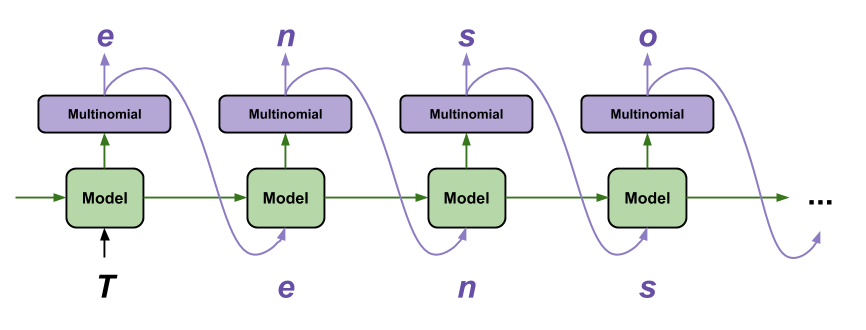

Each time you call the model you pass in some text and an internal state. The model returns a prediction for the next character and its new state. Pass the prediction and state back in to continue generating text.

The following makes a single step prediction:

In [49]:
class OneStep(tf.keras.Model):
  def __init__(self, model, chars_from_ids, ids_from_chars, temperature=1.0):
    super().__init__()
    self.temperature = temperature
    self.model = model
    self.chars_from_ids = chars_from_ids
    self.ids_from_chars = ids_from_chars

    # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = self.ids_from_chars(['[UNK]'])[:, None]
    sparse_mask = tf.SparseTensor(
        # Put a -inf at each bad index.
        values=[-float('inf')]*len(skip_ids),
        indices=skip_ids,
        # Match the shape to the vocabulary
        dense_shape=[len(ids_from_chars.get_vocabulary())])
    self.prediction_mask = tf.sparse.to_dense(sparse_mask)

  @tf.function
  def generate_one_step(self, inputs, states=None):
    # Convert strings to token IDs.
    input_chars = tf.strings.unicode_split(inputs, 'UTF-8')
    input_ids = self.ids_from_chars(input_chars).to_tensor()

    # Run the model.
    # predicted_logits.shape is [batch, char, next_char_logits]
    predicted_logits, states = self.model(inputs=input_ids, states=states,
                                          return_state=True)
    # Only use the last prediction.
    predicted_logits = predicted_logits[:, -1, :]
    predicted_logits = predicted_logits/self.temperature
    # Apply the prediction mask: prevent "[UNK]" from being generated.
    predicted_logits = predicted_logits + self.prediction_mask

    # Sample the output logits to generate token IDs.
    predicted_ids = tf.random.categorical(predicted_logits, num_samples=1)
    predicted_ids = tf.squeeze(predicted_ids, axis=-1)

    # Convert from token ids to characters
    predicted_chars = self.chars_from_ids(predicted_ids)

    # Return the characters and model state.
    return predicted_chars, states

In [50]:
one_step_model = OneStep(model, chars_from_ids, ids_from_chars)

In [52]:
start = time.time()
states = None
next_char = tf.constant(['A rose for thee'])
result = [next_char]

for n in range(1000):
  next_char, states = one_step_model.generate_one_step(next_char, states=states)
  result.append(next_char)

result = tf.strings.join(result)
end = time.time()
print(result[0].numpy().decode('utf-8'), '\n\n' + '_'*80)
print('\nRun time:', end - start)

A rose for thee; I conjure thee.
How canst thou swear by the garden on the boace?
Seeming to your cousin! hath brief themselves?
Why, then, since you bight what after good, good
But pay no rump: the rest shall count his king:
But where our safer ire, whom thou shouldst be the
seconver to the Capitol.

KING RICHARD II:
Well, Peace be that of true about your
equals; and all the provost, cousin, 'Pamen and fruit the infurment
And smother'd for virtuous danger and our possession
Than my haste way.

DUKE VINCENTIO:
Pray you, le, this; I hold it thee.

KING LEWIS XI:
Then, Poor bride, reasy it him forth from thence.
Save your great conclusion, baids to show a stuty of
one fourer than the is the manner,
Commanded to deliver us their neither grieve
The langus's action and woman living beht,
And, Angelo:--

COMINIUS:
We must toing with many throats
to the contract and suffer'd up.

DUCHESS OF YORK:
A gentleman on my mother, tear it is thy life
Shalt be the vigour lies with honey work,
As if the

# **Export the generator**

In [53]:
tf.saved_model.save(one_step_model, 'one_step')
one_step_reloaded = tf.saved_model.load('one_step')

INFO:tensorflow:Assets written to: one_step/assets


INFO:tensorflow:Assets written to: one_step/assets


In [54]:
states = None
next_char = tf.constant(['ROMEO:'])
result = [next_char]

for n in range(100):
  next_char, states = one_step_reloaded.generate_one_step(next_char, states=states)
  result.append(next_char)

print(tf.strings.join(result)[0].numpy().decode("utf-8"))

ROMEO:
Tell me of thousand, Kate, an end of mercy!

NORFOLK:
Ay, so I did request you.

LEONTES:
We'll he 
